In [ ]:
# Importing the libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

# Multilayer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)

        self.h = 0.1     # step size for spatial domain
        self.k = 0.1     # step size for temporal domain
        x = torch.arange(-1, 1 + self.h, self.h)    # spatial domain range
        t = torch.arange(0, 1 + self.k, self.k)     # temporal domain range

        # exact solution (blanck)
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # training data (blank)
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50_000,
            max_eval=50_000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",      # better numerical stability
        )
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        # making the both optimizer zero
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X,
            outputs=u,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dX,
            grad_outputs=torch.ones_like(du_dX),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

# training the PINNs
net = Net()
net.train()

# Evaluation
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [2]:
# Importing the libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

In [3]:
# Multilayer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)

        self.h = 0.1     # step size for spatial domain
        self.k = 0.1     # step size for temporal domain
        x = torch.arange(-1, 1 + self.h, self.h)    # spatial domain range
        t = torch.arange(0, 1 + self.k, self.k)     # temporal domain range

        # exact solution (blanck)
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # training data (blank)
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50_000,
            max_eval=50_000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",      # better numerical stability
        )
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        # making the both optimizer zero
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X,
            outputs=u,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dX,
            grad_outputs=torch.ones_like(du_dX),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

## Training

In [6]:
net = Net()
net.train()

/home/gopal2751765/sklearn-env/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.18822091817855835
200 0.09888169914484024
300 0.07409267127513885
400 0.05038738250732422
500 0.025408338755369186
600 0.019280653446912766
700 0.016773134469985962
800 0.01475989818572998
900 0.02105015143752098
1000 0.012241329997777939
1100 0.007898847572505474
1200 0.005069940350949764
1300 0.0027016564272344112
1400 0.0018585014622658491
1500 0.001402148394845426
1600 0.0011768005788326263
1700 0.0009107321384362876
1800 0.0007060979842208326
1900 0.000609078910201788
2000 0.0005390439764596522
2100 0.0004391529655549675
2200 0.000345197826391086
2300 0.0002777483605314046
2400 0.00023591906938236207
2500 0.0002197450667154044
2600 0.00019342591986060143
2700 0.0001719862048048526
2800 0.0001562934776302427
2900 0.00013836679863743484
3000 0.0001227922912221402
3100 0.00011638013529591262
3200 0.00010810172534547746
3300 0.0001000400516204536
3400 9.607247193343937e-05


## Evaluation

In [41]:
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [42]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [49]:
x_space = x.cpu().numpy()
t_time = t.cpu().numpy()

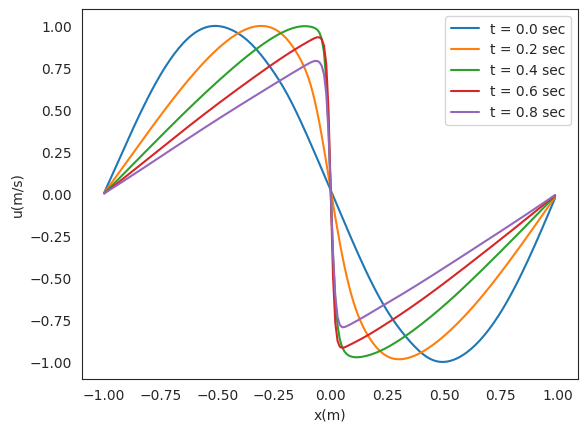

In [57]:
# sns.set_style('white')
# plt.figure(figsize=(5, 3), dpi=3000)
# sns.heatmap(y_pred, cmap='jet')
for i in range(0, len(t_time), 20):
    plt.plot(x_space,y_pred[:, i], label=f't = {i/100} sec')
plt.xlabel('x(m)')
plt.ylabel('u(m/s)')
plt.legend()
plt.show()